In [161]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import skimage.segmentation as seg
import skimage.filters as filters
from skimage.morphology import disk
from skimage.measure import label
from skimage.color import label2rgb
from skimage import exposure
import cv2
from skimage.morphology import diamond
from scipy import ndimage as ndi

Создадим 2 собственные функции для отображения картинки и гистограммы изображения. Загрузим исходное изображение. 

(<Figure size 1008x1008 with 1 Axes>, <AxesSubplot:>)

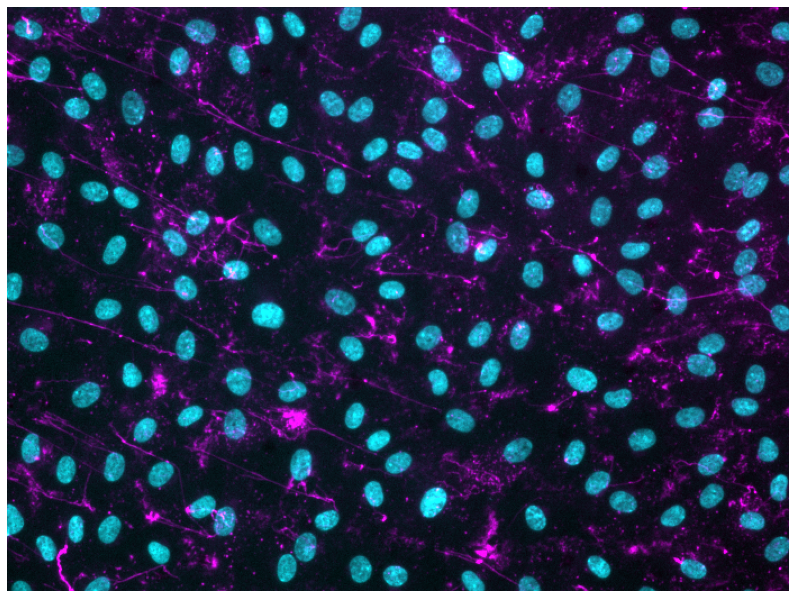

In [162]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

def hist_show(image):
    fig, ax = plt.subplots(1, 1)
    ax.hist(image.ravel(), bins=32, range=[0, 256])
    ax.set_xlim(0, 256)

Composite = io.imread('F:\\Sasha\\Composite.png')
image_show(Composite)

Загрузим картинку для нашего анализа поканально в формате png. В С1 у нас будет хранится сигнал с поверхности клеток, в С3 - ядра.

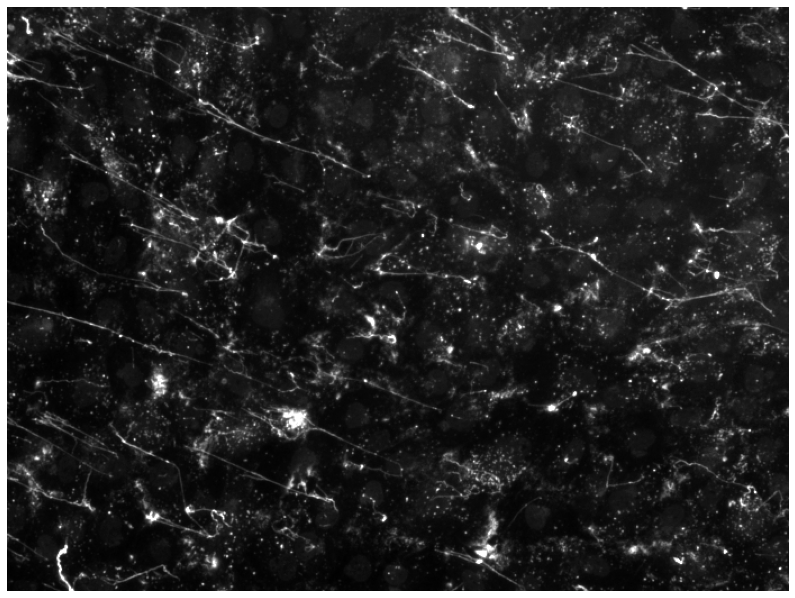

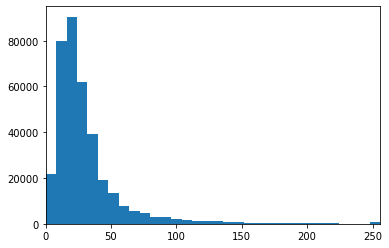

In [163]:
C1 = io.imread('F:\\Sasha\\C1.png')
image_show(C1)
hist_show(C1)

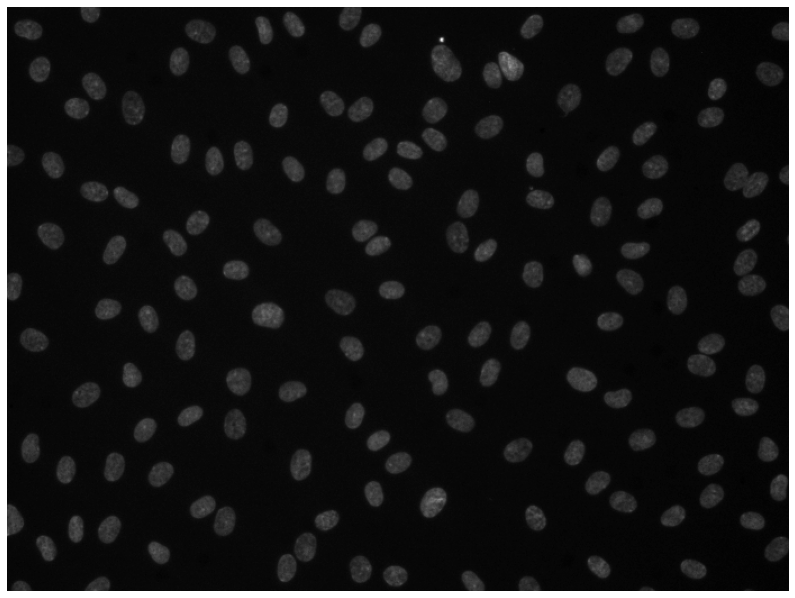

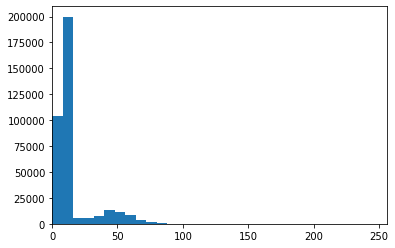

In [164]:
C3 = io.imread('F:\\Sasha\\C3.png')
image_show(C3)
hist_show(C3)

Для начала обработаем изображение С3 медианным фильтром с использованием морфологического фильтра disk с ядром 3. Выведем получившуюся картинку и ее гистограмму.

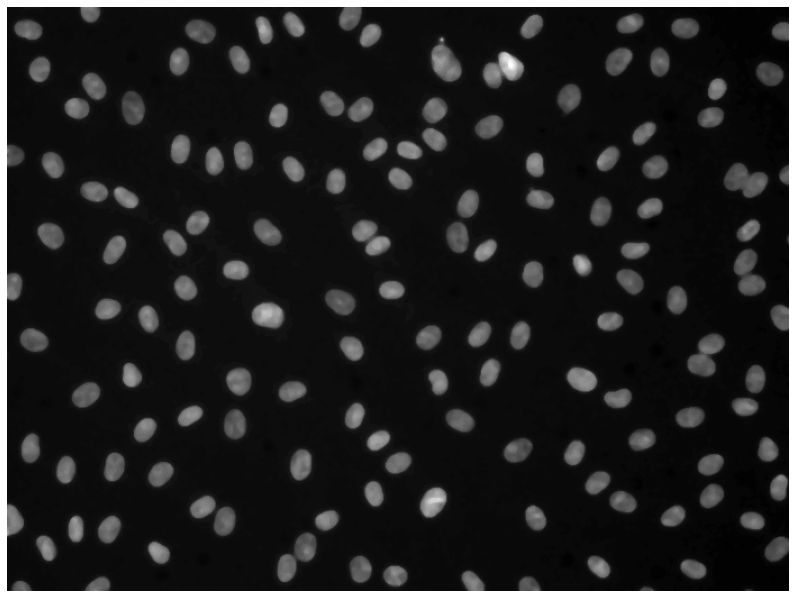

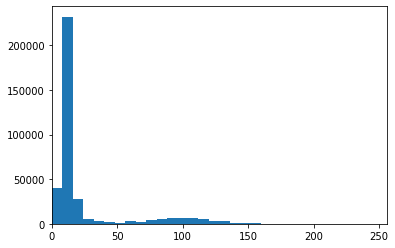

In [165]:
C3_med = filters.median(C3, disk(3))
C3_med = exposure.rescale_intensity(C3_med)
image_show(C3_med)
hist_show(C3_med)

Создадим маску, которая будет очерчивать наши объекты, уровень трешхолда поставим исходя из гистограммы С3_med.
Те ядра, что касаются края изображения удалим.  Некоторые ядра не разделились полностью, попробуем разделить их другим методом. 

(<Figure size 1008x1008 with 1 Axes>, <AxesSubplot:>)

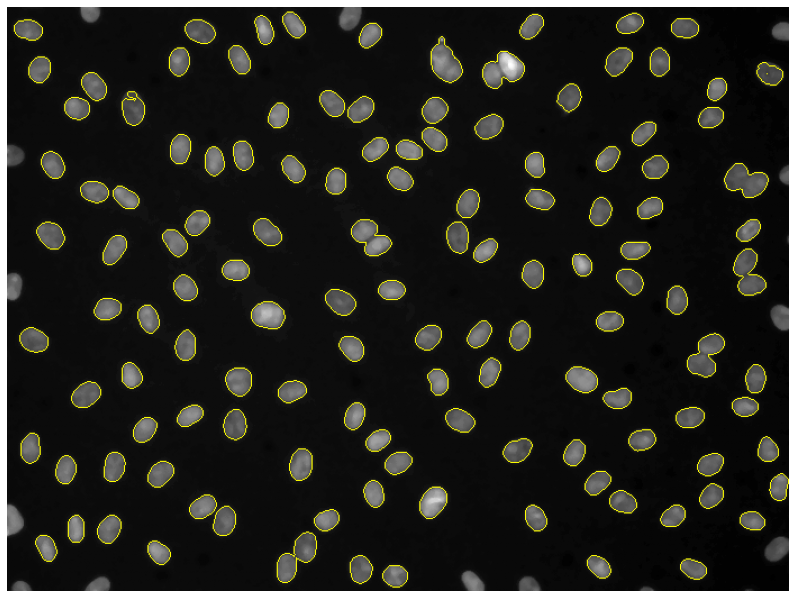

In [177]:
mask = C3_med > 60
clean_border = seg.clear_border(mask)
C3_seg = seg.mark_boundaries(C3_med, clean_border.astype(np.int32))
image_show(C3_seg)

Используем морфологические фильтры чтобы отделить бэкграунд от объектов.

(<Figure size 1008x1008 with 1 Axes>, <AxesSubplot:>)

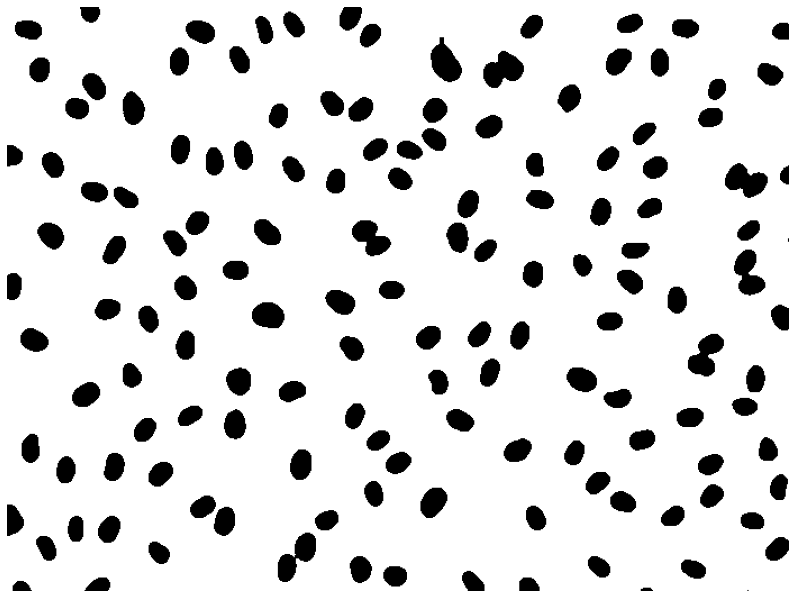

In [205]:
img = cv2.imread('F://Sasha//C3.png')
ret,thresh = cv2.threshold(C3_med,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
sure_bg = cv2.dilate(opening,kernel,iterations=3)
image_show(sure_bg)


(<Figure size 1008x1008 with 1 Axes>, <AxesSubplot:>)

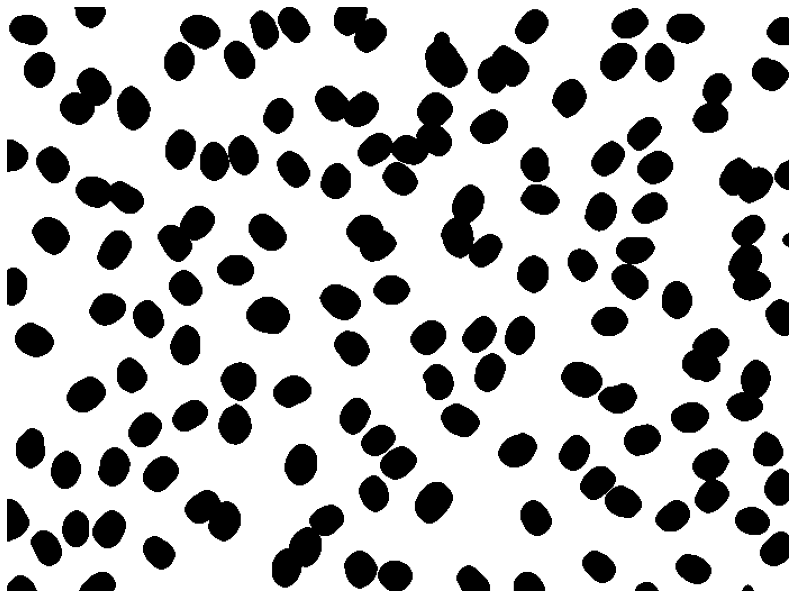

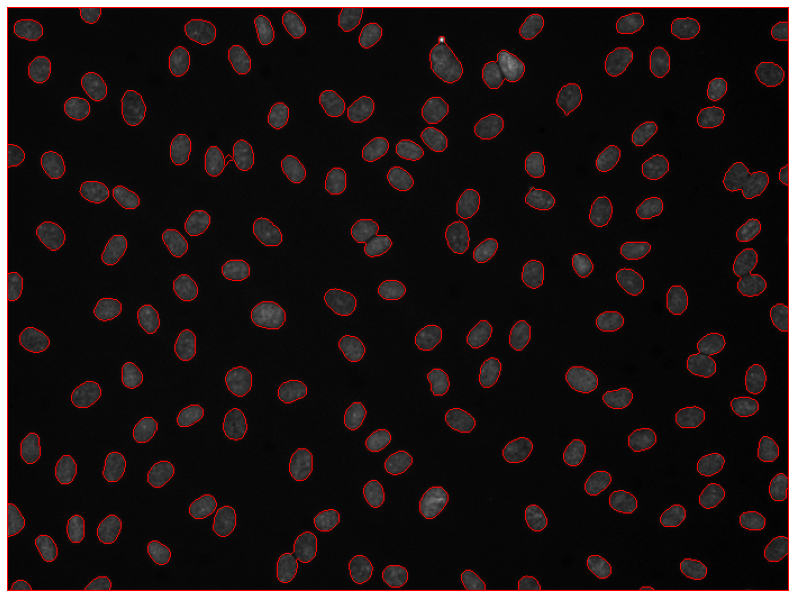

In [202]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)
image_show(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
image_show(img)

In [ ]:
Вторым способом получилось примерно так же как и первым, некоторые ядра слипаются. Перейдем к обработке второй картинки.
Пропустим ее через медианный фильтр с морфологическим фильтром diamond, размера 2. Т.к. картинка очень неоднородная по интенсивности,
проверим разные фарианты трешхолда.

(<Figure size 1008x1008 with 1 Axes>, <AxesSubplot:>)

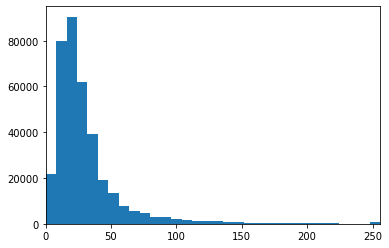

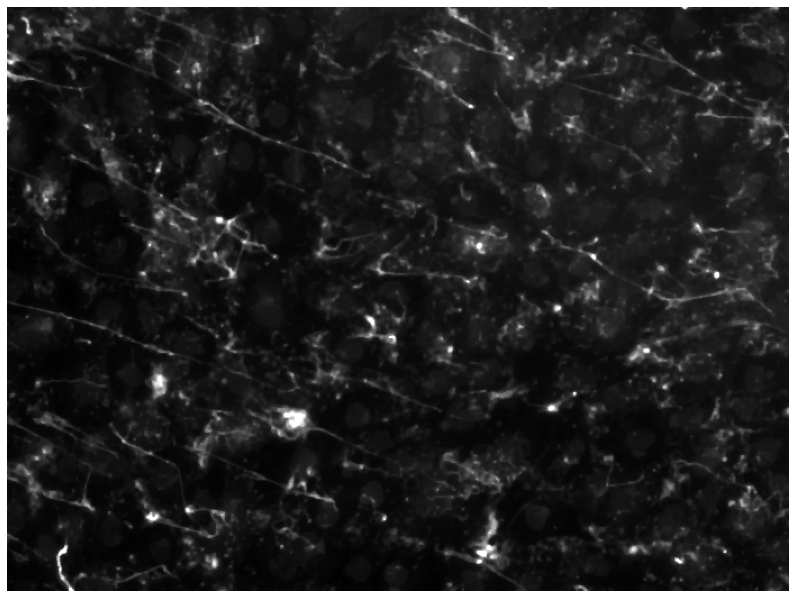

In [208]:
hist_show(C1)
C1_med = filters.median(C1, diamond(2))
image_show(C1_med)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


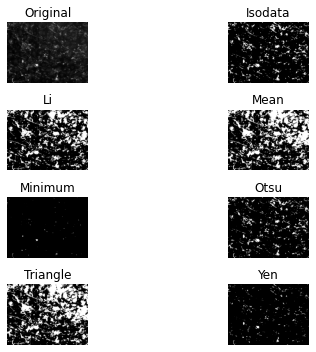

In [209]:
tresholded = filters.thresholding.try_all_threshold(C1_med)

Воспользуемся алгоритмом трешхолда isodata.

Threshold value is 53


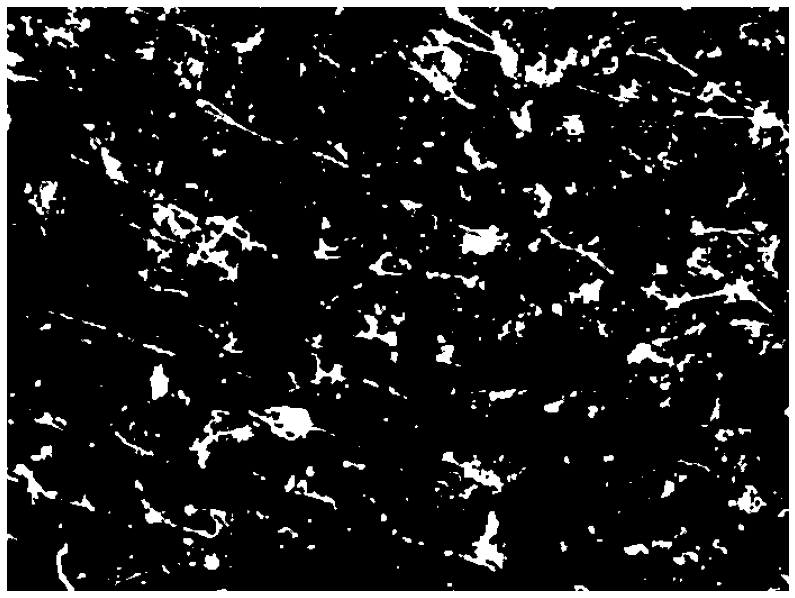

In [210]:
threshold = filters.threshold_isodata(C1_med)
print("Threshold value is {}".format(threshold))
predicted = np.uint8(C1_med > threshold) * 255
image_show(predicted)
labeled = label(predicted)

In [ ]:
Присвоим определенным объектам цветные лейблы.

(<Figure size 1008x1008 with 1 Axes>, <AxesSubplot:>)

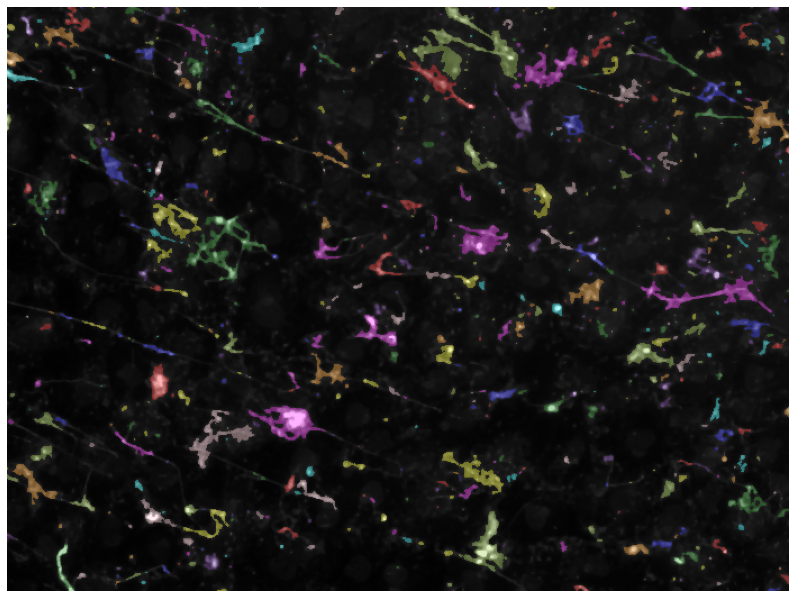

In [212]:
image_label_overlay = label2rgb(labeled, image=C1_med, bg_label=0)
image_show(image_label_overlay)